# Collaborative Filtering Algorithm
## Recommemder System using Collaborative Filtering Algorithm
### This is an implementation of Collaborative Filtering Algorithm, based on the lecture of Andrew NG on the corresponding topic in Coursera.
### Dataset source: https://www.kaggle.com/grouplens/movielens-20m-dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from textwrap import wrap

# Set default fontsize and colors for graphs
SMALL_SIZE, MEDIUM_SIZE, BIG_SIZE = 8, 12, 16
plt.rc('font', size=MEDIUM_SIZE)       
plt.rc('axes', titlesize=BIG_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIG_SIZE)
my_colors = 'rgbkymc'

# Disable scrolling for long output
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [2]:
# Read the input training and test data
input_data_file_movie = "C:\Study\DataSets\movielens-20m-dataset\\movie.csv"
input_data_file_rating = "C:\Study\DataSets\movielens-20m-dataset\\rating.csv"

movie_data = pd.read_csv(input_data_file_movie)
rating_data = pd.read_csv(input_data_file_rating)

In [3]:
movie_data.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating_data.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
print("Total number of movies =", movie_data.shape[0])
print("Total number of unique movies =", len(movie_data.movieId.unique()))
print("")
print("Total number of user ratings =", rating_data.shape[0])
print("Total number of unique users =", len(rating_data.userId.unique()))

Total number of movies = 27278
Total number of unique movies = 27278

Total number of user ratings = 20000263
Total number of unique users = 138493


In [6]:
# Keep only required columns
movie_data = movie_data.drop(['genres'], axis=1)
rating_data = rating_data.drop(['timestamp'], axis=1)

In [7]:
# Test with a subset of data
num_movies = 500
num_ratings = 10000
movie_data = movie_data.iloc[:num_movies, :]
rating_data = rating_data.iloc[:num_ratings, :]

In [8]:
movie_rating_merged_data = movie_data.merge(rating_data, on='movieId', how='inner')
movie_rating_merged_data.tail()

,movieId,title,userId,rating
2141,500,Mrs. Doubtfire (1993),90,4.0
2142,500,Mrs. Doubtfire (1993),91,4.0
2143,501,Naked (1993),38,5.0
2144,501,Naked (1993),56,3.0
2145,502,"Next Karate Kid, The (1994)",29,3.0


In [9]:
# Mean rating of a movie
movie_rating_merged_data[movie_rating_merged_data.title == 'Toy Story (1995)']['rating'].mean()

4.035714285714286

In [10]:
# Top 10 movies by mean rating
movie_rating_merged_data.groupby(['title'], sort=False)['rating'].mean().sort_values(ascending=False).head(10)

title
I'll Do Anything (1994)                                           5.0
Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)    5.0
Living in Oblivion (1995)                                         5.0
Burnt by the Sun (Utomlyonnye solntsem) (1994)                    5.0
Goofy Movie, A (1995)                                             5.0
Amateur (1994)                                                    5.0
Star Maker, The (Uomo delle stelle, L') (1995)                    5.0
Live Nude Girls (1995)                                            5.0
White Squall (1996)                                               5.0
Unzipped (1995)                                                   5.0
Name: rating, dtype: float64

In [11]:
movie_rating_merged_pivot = pd.pivot_table(movie_rating_merged_data,
                                           index=['title'],
                                           columns=['userId'],
                                           values=['rating'],
                                           dropna=False,
                                           fill_value=0
                                          )
movie_rating_merged_pivot.shape

(317, 90)

In [12]:
Y = movie_rating_merged_pivot

In [13]:
R = np.ones(Y.shape)
no_rating_idx = np.where(Y == 0.0)
R[no_rating_idx] = 0
R

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
n_u = Y.shape[1]
n_m = Y.shape[0]
n_f = 10
reg_lambda = 1
alpha = 0.01
num_iters = 50000

In [24]:
Initial_X = np.random.rand(n_m, n_f)
Initial_Theta = np.random.rand(n_u, n_f)
#print("Initial_X =", Initial_X)
#print("Initial_Theta =", Initial_Theta)

In [25]:
# Cost Function
def collabFilterCostFunction(X, Theta, Y, R, reg_lambda=0):
    cost = 0
    error = (np.dot(X, Theta.T) - Y) * R
    error_sq = np.power(error, 2)
    cost = np.sum(np.sum(error_sq)) / 2
    cost = cost + (reg_lambda/2) * ( np.sum(np.sum((np.power(X, 2)))) 
                                    + np.sum(np.sum((np.power(Theta, 2)))) )
    return cost
    
#collabFilterCostFunction(X, Theta, Y, R, reg_lambda=0)

In [26]:
# Gradient Descent
def collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters):
    cost_history = np.zeros([num_iters, 1])
    
    for i in range(num_iters):
        error = (np.dot(X, Theta.T) - Y) * R
        X_grad = np.dot(error, Theta) + reg_lambda * X
        Theta_grad = np.dot(error.T, X) + reg_lambda * Theta
        
        X = X - alpha * X_grad 
        Theta = Theta - alpha * Theta_grad
        
        cost_history[i] = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
        
    return X, Theta, cost_history

alpha = 0.0001
num_iters = 10000
reg_lambda = 0
X, Theta = Initial_X, Initial_Theta
X, Theta, cost_history = collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters)
collabFilterCostFunction(X, Theta, Y, R, reg_lambda)

90.35667272969796

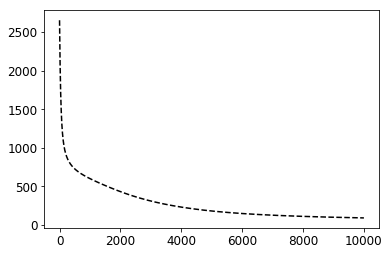

In [27]:
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(cost_history, 'k--')
plt.show()

In [28]:
np.dot(X, Theta.T)[0], Y.iloc[0,:]

(array([ 3.59790481,  3.30216359,  2.27822862,  2.20883974,  3.88334337,
         2.99898098,  1.6696848 ,  3.04863142,  3.81392102,  3.82394627,
         4.02974117,  3.27648372,  2.56133405,  2.28979642,  2.55167283,
         2.06467661,  4.04126675,  2.67399861,  1.77865429,  2.47963676,
         2.21074292,  2.55257458,  5.16256459,  4.77187023,  3.49286263,
         2.79417736,  3.92213583,  1.79609874,  2.83321044,  1.69513965,
         2.57102902,  3.79496426,  3.61673175,  3.12754508,  2.3512749 ,
         2.80180125,  1.76424641,  2.93585088, -0.57230219,  3.16509855,
         3.00268601,  2.20314535,  2.52893189,  1.49297224,  3.6665171 ,
         1.1053773 ,  4.00475873,  3.24154441,  2.44914706,  4.93476444,
         2.80565386,  2.11833686,  1.12749843,  3.61416776,  1.92217881,
         3.35754431,  3.17868299,  3.03896439,  3.5396666 ,  0.51152483,
         3.96647569,  2.63598751,  3.11887605,  4.2596454 ,  4.48941675,
         3.67261707,  4.40593013,  3.77532339,  3.1

In [29]:
Y.iloc[:,0].sort_values(ascending=False)

title
Star Wars: Episode IV - A New Hope (1977)                                          4.0
Pulp Fiction (1994)                                                                4.0
Rob Roy (1995)                                                                     4.0
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)                     4.0
Interview with the Vampire: The Vampire Chronicles (1994)                          4.0
Shawshank Redemption, The (1994)                                                   4.0
Clerks (1994)                                                                      4.0
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                                          3.5
City of Lost Children, The (Cité des enfants perdus, La) (1995)                    3.5
Usual Suspects, The (1995)                                                         3.5
Seven (a.k.a. Se7en) (1995)                                                        3.5
Rumble in the Bronx (Hont faan kui) (

In [30]:
predicted_ratings = np.dot(X, Theta.T)
sorted(zip(predicted_ratings[:,0], Y.index), reverse=True)
#sorted(predicted_ratings[:,0], reverse=True)

[(5.307288207727703, 'Flirting With Disaster (1996)'),
 (5.175549776880924, 'Richard III (1995)'),
 (4.8420346833959265, 'Amateur (1994)'),
 (4.785907734936438,
  'Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)'),
 (4.781310293955221, 'Postman, The (Postino, Il) (1994)'),
 (4.767228011744899, 'Restoration (1995)'),
 (4.6774443702668576, 'Bullets Over Broadway (1994)'),
 (4.676316786385965, 'Burnt by the Sun (Utomlyonnye solntsem) (1994)'),
 (4.65190820308614, 'Kids (1995)'),
 (4.613275200141752, 'Before Sunrise (1995)'),
 (4.547188066187128, 'Legends of the Fall (1994)'),
 (4.520934426171855, 'Immortal Beloved (1994)'),
 (4.504557213737485, 'Persuasion (1995)'),
 (4.424010631079102, 'Toy Story (1995)'),
 (4.411861740114767, 'Unzipped (1995)'),
 (4.377234344137826, 'Little Women (1994)'),
 (4.372805904404201, 'Leaving Las Vegas (1995)'),
 (4.36937446536019, 'Much Ado About Nothing (1993)'),
 (4.361748511347454, 'Four Weddings and a Funeral (1994)'),
 (4.336435056999997, 

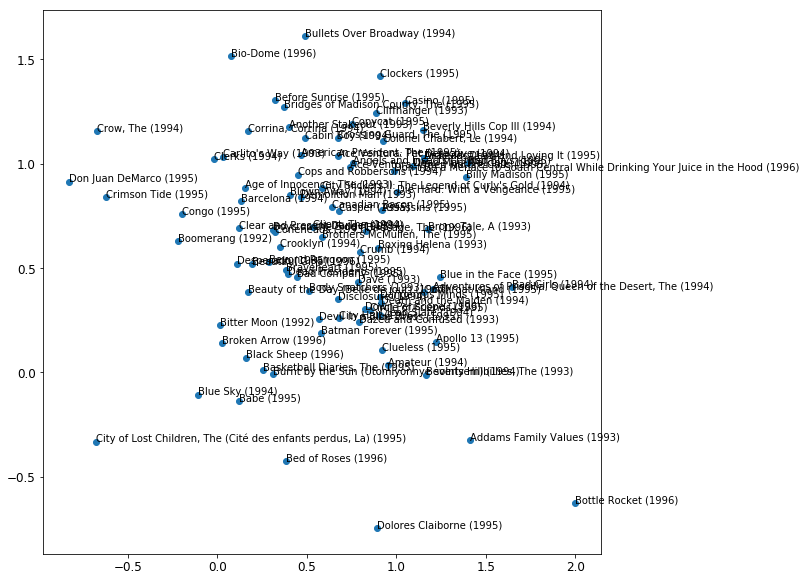

In [31]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(Theta[:,0], Theta[:,1])

for val, movie in zip(Theta, Y.index):
    axes.text(val[0], val[1], movie)

plt.show()